In [1]:
import pm4py
import pandas as pd
import numpy as np

# pd.options.display.max_rows = 1000
pd.options.display.max_columns = 200
pd.options.display.max_colwidth = 200

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
import pm4py.objects.log.exporter.xes.exporter as xes_export

# replace: 
# value="([A-Z])(.*):(.*)"
# value="$1$2 - $3"

In [3]:
log = pd.read_csv("abstract_log-starts_ends-cov_var_75perc.csv")
log['time:timestamp'] = pd.to_datetime(log['time:timestamp'])

## Method 2: frequent - simult

took subset of log with only 'candidate' & 'integrated' keywords
why this choice? they all seem to start and end at more or less the same event, with a bunch of spaghetti in between
and, they have similar names ...
so, still kind of considering subprocesses
can still consider replacing all these events with single "sub"event, since they have complicated relations with other events (in particular, auto-promote and such); would lose some information, but who cares

tried frequent itemset mining to get frequent combinations of subset's events
in the end, simply considered all subset's events together
(was mucking about with individual pairs; if simult, ensuring a particular ordering. didn't make much difference & labor intensive.)

with all events taken together, they are "simulteneous" (within 10min) in 75% cases
eventually, removed all "simultaneous" events from the log to get "real" orderings
-> log3

looking at variants _per log subset_ turned out a good idea; zoomed in on certain parts
after checking the discovered petri net & variants, it seemed the following holds, more or less:
cand search:start -> integr search:start -> integr search:end -> cand search:end
 										    cand id:start ~> cand id dec:start -> cand id:end ~> cand id dec:end

used declare miner (RuM tool) - it finds more or less the same constraints; especially when looking at the automaton
but difficult to read ... it seems some of the constraints are inferrable (transitivity; X r Y r Z -> X r Z)
-> search-found-rum-automaton, search-found-rum-constraints

(declarepy goes completely off the deep end for same log; search-found-decl4py-constraints)

manually created a more minimal decl model based on the above
-> search-manual-loose (not fully compliant), search-manual-strict (full compliance)

dcr4py: much better & minimal model - 100% corresponds to hand-drawn one



then, took subset of 'biographic' & 'biometric' events (minus 'fees')
~same criteria for choice as before (perhaps not as clear "start" and "end" events)

not as much luck with simultaneous events
variants (log3) were not very enlightening either

dcr4py: got minimal model that corresponds a bit to inductive miner output (latter when using variants!)



subset of 'medical' events
purely based on labels here

95% of events are simultaneous (within 10 minutes; 92% within 1 minute)
only 8 variants

makes most sense:
(o) Medical:Not Started -> Medical Assessment:Not Started -> Medical:Passed, Medical Assessment:Passed -> (o)
														  -> skip -> (o)



subset of 'criminality'
purely on labels

only 2 variants; 1 with a coverage of 1
quite simple!



subset of 'fees' (outstanding / paid)
purely on labels

mostly same timestamps (99.5 are absolutely identical)
so, would keep ordering b/w outstanding/paid pairs, but nothing else



TODO: replace these subsets with start/end events, as before
see what happens!! XD

TODO: try dcr on entire log, for sh*ts & giggles

### Candidate / Integrated Search

In [ ]:
log2 = log[(log['concept:name'].str.contains("Candidate")) | log['concept:name'].str.contains("Integrated")]
log2

In [ ]:
xes_export.apply(log2, "lifecycles/manual/logs/Candidate_Integrated_Search-all.xes")

In [ ]:
from mine_utils import mine_alpha
mine_alpha(log2)

In [ ]:
traces = log2.groupby('case:concept:name')['concept:name'].apply(tuple).to_list()
traces

In [ ]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(traces).transform(traces)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

In [ ]:
from mlxtend.frequent_patterns import apriori, fpgrowth

# itemsets = apriori(df, min_support=0.5, use_colnames=True)
itemsets = fpgrowth(df, min_support=0.6, use_colnames=True)
itemsets['length'] = itemsets['itemsets'].apply(lambda x: len(x))
itemsets = itemsets[itemsets['length'] >= 2]
# itemsets.to_csv("itemsets-method2.csv")
itemsets

In [ ]:
itemset = itemsets['itemsets'].iloc[-1]
itemset

In [ ]:
from mine_utils import aggregate_events

# itemset = ('Integrated Search:end', 'Candidate Search:end')
# 13,0.9998259658893143,"frozenset({'Candidate Search:end', 'Integrated Search:end'})",2
# groups: 5746 total size: 11491 avg size: 1.9998259658893143
# groups: 5746 # simult: 5746 avg: 100.0 %
# groups: 5746 avg_diff: 1980 s ( 33 m )
# {('Integrated Search:end', 'Candidate Search:end'): 0, ('Candidate Search:end', 'Integrated Search:end'): 0}

# itemset = ('Candidate ID Decision:end','Candidate ID Decision:start','Candidate ID:end','Candidate ID:start','Candidate Search:end','Candidate Search:start','Integrated Search:end','Integrated Search:start')
# groups: 5746 total size: 45544 avg size: 7.93
# groups: 5746 # simult: 4349 avg: 75.69 %
# groups: 5746 avg_diff: 23314 s ( 388 m )

# for itemset in itemsets['itemsets']:
#     print(itemset)
max_timedelta = 10 * 60 # * pow(10,9) # nano to seconds
log3 = aggregate_events(log2, itemset, max_timedelta)

# print()

# 'Integrated Search:end' -> 'Candidate Search:end'

In [ ]:
log3 = log3.sort_values(by=['case:concept:name', 'time:timestamp'])

In [ ]:
# double checking for when replacing timestamps

# diff = log3[log3['concept:name'].isin(itemset)].groupby('case:concept:name')['time:timestamp'].diff().astype(int)
# diff = diff / pow(10, 9)
# diff[(diff > 0) & (diff != 1)]

In [ ]:
from mine_utils import mine_alpha
mine_alpha(log3)

In [ ]:
from variant_stats import get_variants_stats, get_covering_variants, filter_traces_on_variants

var_stats = get_variants_stats(log3)
var_stats

In [ ]:
log3.to_csv("lifecycles/manual/logs/Candidate_Integrated_Search-filtered.csv")
xes_export.apply(log3, "lifecycles/manual/logs/Candidate_Integrated_Search-filtered.xes")

### Biometric / Biographic (minus fees)

In [ ]:
log2 = log[((log['concept:name'].str.contains("Biometric")) | log['concept:name'].str.contains("Biographic")) & (~ log['concept:name'].str.contains("Fee"))]
log2

In [ ]:
from mine_utils import mine_induct
mine_induct(log2)

In [ ]:
log2.to_csv("lifecycles/manual/logs/Biometric_Biographic-all.csv")
xes_export.apply(log2, "lifecycles/manual/logs/Biometric_Biographic-all.xes") 

In [ ]:
from variant_stats import get_variants_stats, get_covering_variants, filter_traces_on_variants

var_stats = get_variants_stats(log2)
var_stats

In [ ]:
cov_var = get_covering_variants(90, var_stats)
log3 = filter_traces_on_variants(log2, cov_var)

In [ ]:
mine_induct(log3)

In [ ]:
log3.to_csv("lifecycles/manual/logs/Biometric_Biographic-filtered.csv")
xes_export.apply(log3, "lifecycles/manual/logs/Biometric_Biographic-filtered.xes") 

In [ ]:
itemset = log2['concept:name'].unique()
itemset

In [ ]:
max_timedelta = 10 * 60 # * pow(10,9) # nano to seconds
log3 = aggregate_events(log2, itemset, max_timedelta)

### Medical

In [ ]:
log2 = log[log['concept:name'].str.contains("Medical")]
log2

In [ ]:
from mine_utils import mine_induct
mine_induct(log2)

In [ ]:
log2.to_csv("lifecycles/manual/logs/Medical-all.csv")
xes_export.apply(log2, "lifecycles/manual/logs/Medical-all.xes") 

In [ ]:
itemset = log2['concept:name'].unique()

from mine_utils import aggregate_events

max_timedelta = 10 * 60 # * pow(10,9) # nano to seconds
log3 = aggregate_events(log2, itemset, max_timedelta)

In [ ]:
from variant_stats import get_variants_stats, get_covering_variants, filter_traces_on_variants

var_stats = get_variants_stats(log2)
var_stats

In [ ]:
vars = var_stats.iloc[0:4]
log3 = filter_traces_on_variants(log2, vars)
log3

In [ ]:
from mine_utils import mine_induct
mine_induct(log3)

In [ ]:
log3.to_csv("lifecycles/manual/logs/Medical-filtered.csv")
xes_export.apply(log3, "lifecycles/manual/logs/Medical-filtered.xes") 

### Criminality

In [ ]:
log2 = log[log['concept:name'].str.contains("Criminality")]
log2

In [ ]:
log2.to_csv("lifecycles/manual/logs/Criminality-all.csv")
xes_export.apply(log2, "lifecycles/manual/logs/Criminality-all.xes")

In [ ]:
from mine_utils import mine_induct
mine_induct(log2)

In [ ]:
from variant_stats import get_variants_stats, get_covering_variants, filter_traces_on_variants

var_stats = get_variants_stats(log2)
var_stats

In [ ]:
vars = get_covering_variants(99.99, var_stats)
log3 = filter_traces_on_variants(log2, vars)
log3

In [ ]:
from mine_utils import mine_induct
mine_induct(log3)

In [ ]:
log3.to_csv("lifecycles/manual/logs/Criminality-filtered.csv")
xes_export.apply(log3, "lifecycles/manual/logs/Criminality-filtered.xes")

### Fees

In [ ]:
log2 = log[log['concept:name'].str.contains("Fee")]
log2

In [ ]:
from mine_utils import mine_induct
mine_induct(log2)

In [ ]:
log2.to_csv("lifecycles/manual/logs/Fees-all.csv")
xes_export.apply(log2, "lifecycles/manual/logs/Fees-all.xes")

In [ ]:
from variant_stats import get_variants_stats, get_covering_variants, filter_traces_on_variants

var_stats = get_variants_stats(log2)
vars = get_covering_variants(90, var_stats)
log3 = filter_traces_on_variants(log2, vars)

In [ ]:
from mine_utils import mine_induct
mine_induct(log3)

In [ ]:
log3.to_csv("lifecycles/manual/logs/Fees-filtered.csv")
xes_export.apply(log3, "lifecycles/manual/logs/Fees-filtered.xes")

In [ ]:
itemset = log2['concept:name'].unique()
itemset

In [ ]:
max_timedelta = 0 # 1 * 60 # * pow(10,9) # nano to seconds
_ = aggregate_events(log2, itemset, max_timedelta)

### Other

In [ ]:
log[log['concept:name'].str.contains("Application Transfer")]['concept:name'].unique()

In [ ]:
log[log['concept:name'].str.contains("Eligibility")]['concept:name'].unique()

In [ ]:
# does not consider multiple "groups" occurring per case

# max_time_delta = 10 * 60 * pow(10,9) # nano to seconds

# for idx, row in itemsets.iterrows():
#     itemset = row['itemsets']
#     print("itemset:", itemset)
    
#     # filter events to those in the itemset
#     log3 = log2[log2['concept:name'].isin(itemset)]
    
#     # per case, get time differences between itemset events
#     time_diff = log3.groupby('case:concept:name')['time:timestamp'].diff().astype(int)
#     # get those less than the max time delta
#     simult_evts = time_diff[(time_diff >= 0) & (time_diff <= max_time_delta)]
    
#     print("total # events:", log3.shape[0])
#     print("# simult evts:", len(simult_evts), "(", round(len(simult_evts)/log3.shape[0]*100, 2), "%)")
    
#     print()

### Replace

In [4]:
# TODO - per case, will replace all subprocesses with a single start+end
def implode_subprocess(name, subproc_cond, log):
    log_filt = log[subproc_cond]
    
    # per case, for the subprocesses, replace all activity lifecycle events by single start & end event
    sorted_grouped = log_filt.sort_values(['case:concept:name', 'time:timestamp']).groupby('case:concept:name')
    start_evts = sorted_grouped.first().reset_index(); start_evts['concept:name'] = name + ':start'
    end_evts = sorted_grouped.last().reset_index(); end_evts['concept:name'] = name + ':end'
    abstract_log = pd.concat([start_evts, end_evts])
    # abstract_log = end_evts 
    
    others = log[~ subproc_cond]
    abstract_log = pd.concat([ abstract_log, others ], ignore_index=True).sort_values(by=['case:concept:name','time:timestamp'])
    
    return abstract_log

In [5]:
a_log = log

In [6]:
cond = (a_log['concept:name'].str.contains("Candidate")) | a_log['concept:name'].str.contains("Integrated")

a_log = implode_subprocess("Candidate/Integrated Search", cond, a_log)
# a_log[(a_log['concept:name'].str.contains("Candidate")) | a_log['concept:name'].str.contains("Integrated")]

In [7]:
cond = ((a_log['concept:name'].str.contains("Biometric")) | a_log['concept:name'].str.contains("Biographic")) & (~ a_log['concept:name'].str.contains("Fee"))

a_log = implode_subprocess("Biometric_All", cond, a_log)
# a_log[((a_log['concept:name'].str.contains("Biometric")) | a_log['concept:name'].str.contains("Biographic")) & (~ a_log['concept:name'].str.contains("Fee"))]

In [8]:
cond = a_log['concept:name'].str.contains("Medical")

a_log = implode_subprocess("Medical_All", cond, a_log)
# a_log[a_log['concept:name'].str.contains("Medical")]

In [9]:
cond = a_log['concept:name'].str.contains("Criminality")

a_log = implode_subprocess("Criminality_All", cond, a_log)
# a_log[a_log['concept:name'].str.contains("Criminality")]

In [ ]:
cond = a_log['concept:name'].str.contains("Fee")

a_log = implode_subprocess("Fees", cond, a_log)
# a_log[a_log['concept:name'].str.contains("Fee")]

case:concept:name  Unnamed: 0 concept:name      time:timestamp
0                      1           6   Fees:start 2024-06-03 09:20:45
5800                   1           9     Fees:end 2024-06-03 09:20:45
1                      2       47527   Fees:start 2024-06-03 09:20:55
5801                   2       47530     Fees:end 2024-06-03 09:20:55
2                      5      189456   Fees:start 2024-06-03 09:23:42
...                  ...         ...          ...                 ...
11597               7732      318291     Fees:end 2024-06-21 12:53:46
5798                7733      318305   Fees:start 2024-06-06 10:07:34
11598               7733      318308     Fees:end 2024-06-06 10:07:34
5799                7734      318343   Fees:start 2024-06-06 10:37:08
11599               7734      318346     Fees:end 2024-06-06 10:37:08

[11600 rows x 4 columns]

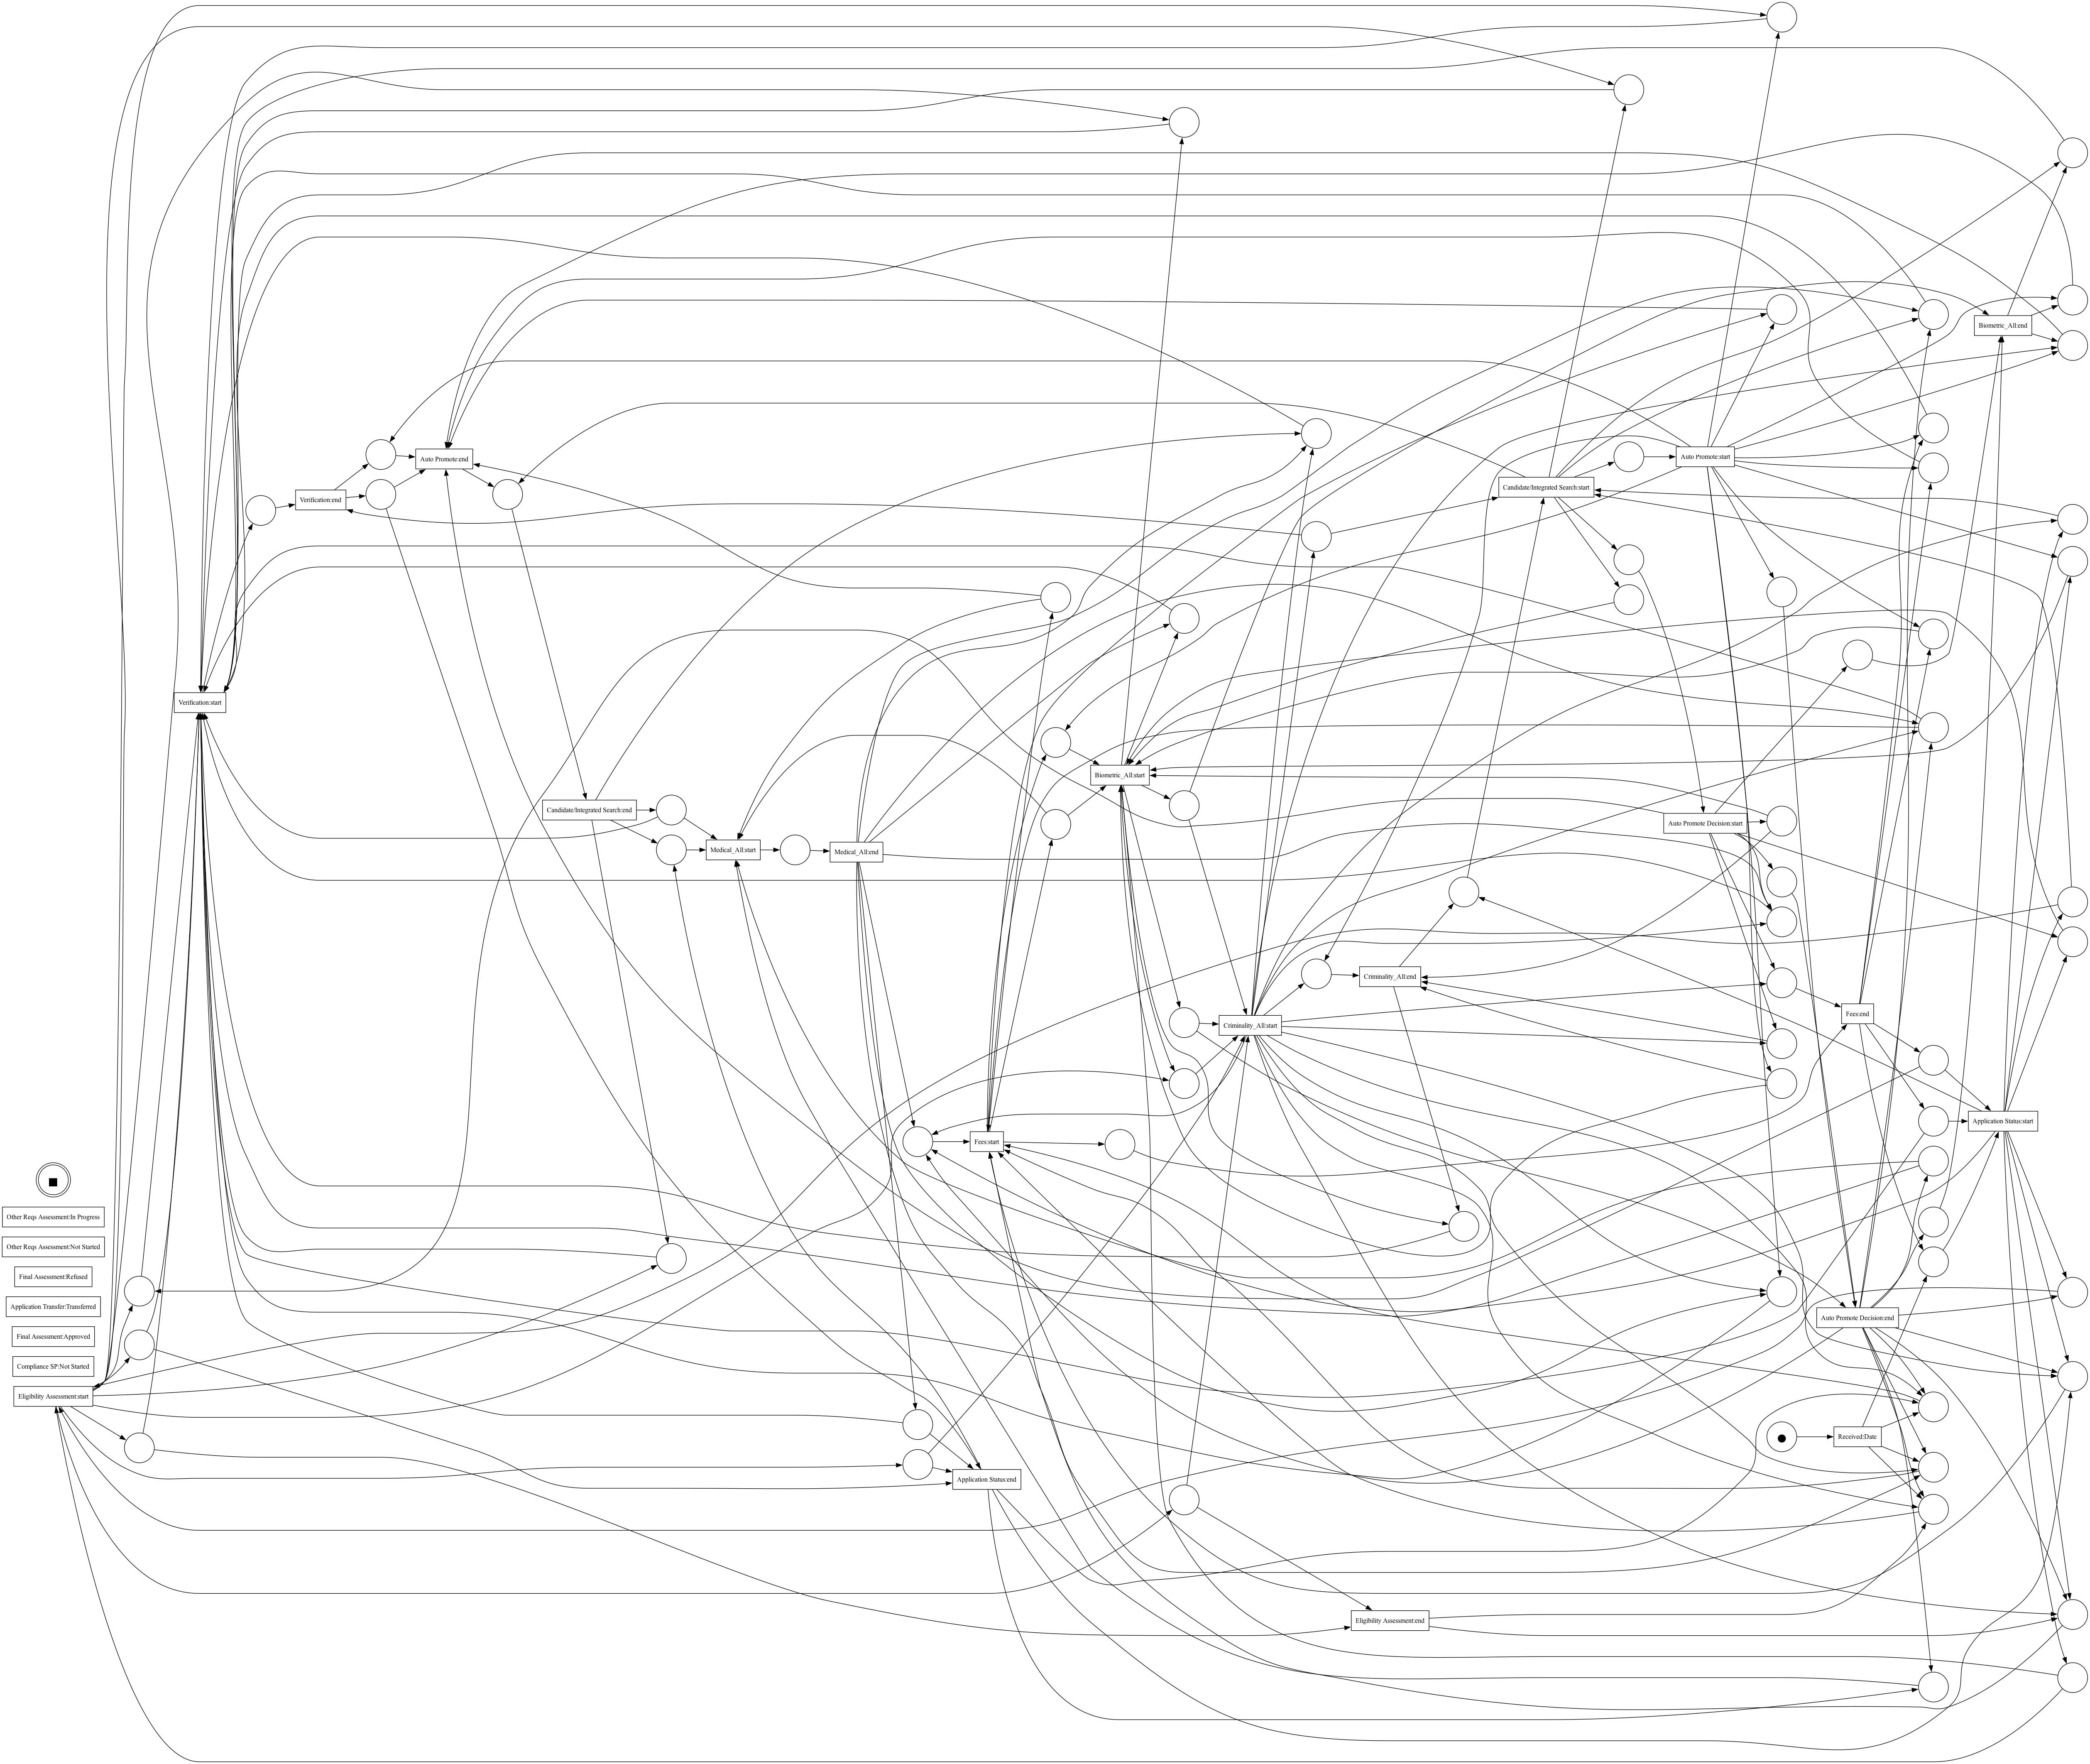

In [14]:
from mine_utils import mine_alpha
mine_alpha(a_log)

## Method 1: simult - frequent

In [ ]:
simult_evts = log.groupby(['case:concept:name', 'time:timestamp'])['concept:name'].apply(tuple)
simult_evts = simult_evts[map(lambda s: len(s)>1, simult_evts)]
simult_evts

In [ ]:
simult_evts.index = simult_evts.index.droplevel(level='time:timestamp')
simult_evts

In [ ]:
simult_evts_list = simult_evts.groupby(level=0).apply(tuple).to_list()
simult_evts_list[0]

In [ ]:
simult_evts[simult_evts.index=="1"]

In [ ]:
log[log['case:concept:name']=="1"]

In [ ]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(simult_evts_list).transform(simult_evts_list)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules

itemsets = apriori(df, min_support=0.1, use_colnames=True)
itemsets.sort_values(by='support', ascending=False).to_csv("tmp.csv")

In [ ]:
rules = association_rules(itemsets, metric ="lift", min_threshold = 1)
rules.sort_values(by='confidence', ascending=False)